In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [108]:
df = pd.read_csv('data/encoded_data.csv')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,0,2,1.957530,-0.119353,-0.381764,6,0,61,1,0,0,-1.174175,0
1,1,0,2,0.299164,-0.089844,-1.120780,6,0,61,0,0,0,-1.174175,0
2,2,0,2,1.747470,-0.030824,1.465775,3,0,36,1,1,0,-1.174175,0
3,1,0,2,0.122272,0.234761,-0.936026,6,0,61,0,0,1,-1.174175,0
4,2,0,2,-0.187290,-0.030824,1.096267,3,0,36,1,0,1,-1.174175,0


In [109]:
#Random resampling to under sample the majority class
print(df[df['booking_complete'] == 1].shape)
print(df[df['booking_complete'] == 0].shape)
df_majority = df[df['booking_complete'] == 0].sample(10000)
df_minority = df[df['booking_complete'] == 1]
df = pd.concat([df_majority, df_minority])
df = df.sample(len(df))

(7478, 14)
(42522, 14)


In [110]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

In [85]:
#Hyper parameter tuning
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}
rfc = RandomForestClassifier(random_state=42)

# Create a grid search object
grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5
)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

(8739, 13)

In [ ]:
grid_search.best_params_

In [ ]:
# after hp tuning, best params were
# params = {'max_depth': None,
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 100}

In [112]:
rf_model = RandomForestClassifier(max_depth = 10, random_state=5, min_samples_leaf = 2, min_samples_split= 2, n_estimators= 100, max_features='sqrt')
rf_model.fit(X, y)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=5)

In [113]:
scores = cross_val_score(rf_model, X, y, cv=5)

In [114]:
print('5 fold - cross validation scores are ', scores)
print('Average cross validation score is ', np.mean(scores))
print('Standard deviation ', np.std(scores))

5 fold - cross validation scores are  [0.70451945 0.70051487 0.7028032  0.70729614 0.69413448]
Average cross validation score is  0.7018536287537279
Standard deviation  0.004449870882572593


In [115]:
rf_model.fit(X_train, y_train)
y_predict = rf_model.predict(X_test)

In [116]:
#importance of features
rf_importance = rf_model.feature_importances_
rf_importance = pd.Series(rf_importance, index=X.columns)
rf_importance = rf_importance * 100
rf_importance

num_passengers            2.245209
sales_channel             2.416408
trip_type                 0.583624
purchase_lead             8.252250
length_of_stay           11.634071
flight_hour               5.644116
flight_day                3.359749
route                    14.081940
booking_origin           34.587282
wants_extra_baggage       3.853388
wants_preferred_seat      1.839979
wants_in_flight_meals     1.720827
flight_duration           9.781157
dtype: float64

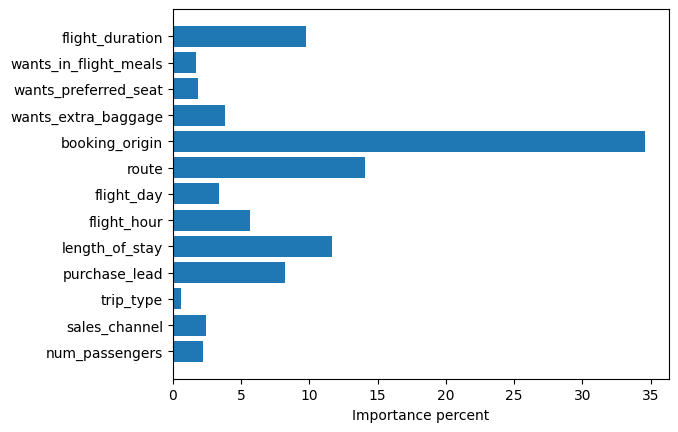

In [117]:
import matplotlib.pyplot as plt
plt.barh(rf_importance.index, rf_importance)
plt.xlabel('Importance percent')
plt.show()

In [118]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_predict)
pd.Series(y_predict).value_counts()

0    1013
1     735
dtype: int64

<Axes: >

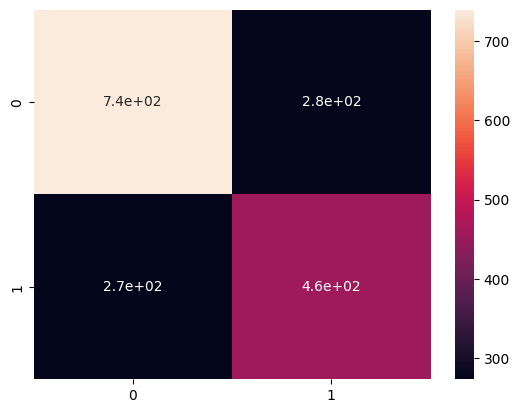

In [119]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)